## Multi-Class Intrusion type detection : Intrusion type detection for attack type increases system complexity

### 전처리

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets, metrics, tree, svm, neighbors
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neighbors import NearestCentroid

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [28]:
# , usecols = ['IPV4_SRC_ADDR','L4_SRC_PORT','IPV4_DST_ADDR','L4_DST_PORT','PROTOCOL','L7_PROTO','IN_BYTES','IN_PKTS','OUT_BYTES','OUT_PKTS','TCP_FLAGS','CLIENT_TCP_FLAGS','SERVER_TCP_FLAGS','FLOW_DURATION_MILLISECONDS','DURATION_IN','MIN_TTL','MAX_TTL','LONGEST_FLOW_PKT','SHORTEST_FLOW_PKT','MIN_IP_PKT_LEN','MAX_IP_PKT_LEN','SRC_TO_DST_SECOND_BYTES','DST_TO_SRC_SECOND_BYTES','SRC_TO_DST_AVG_THROUGHPUT','DST_TO_SRC_AVG_THROUGHPUT','NUM_PKTS_UP_TO_128_BYTES','TCP_WIN_MAX_IN','TCP_WIN_MAX_OUT','ICMP_TYPE','ICMP_IPV4_TYPE','DNS_QUERY_ID','DNS_QUERY_TYPE','DNS_TTL_ANSWER','FTP_COMMAND_RET_CODE','Label','Attack']
df = pd.read_csv("NF-UQ-NIDS-v2.csv",index_col=False, nrows=1)
cols = df.columns
df1 = pd.read_csv("NF-UQ-NIDS-v2.csv", header=None, names=cols, skiprows=1, nrows=200000, index_col=False)
df2 = pd.read_csv("NF-UQ-NIDS-v2.csv", header=None, names=cols, skiprows=5000001, nrows=200000, index_col=False)
df3 = pd.concat([df1, df2], ignore_index = True)

# df = pd.read_csv("NF-UQ-NIDS-v2_sample.csv",chunksize=1000000)

In [29]:
df1.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack,Dataset
0,192.168.100.148,65389,192.168.100.7,80,6,7.0,420,3,0,0,...,0,35840,140,0,0,0,0.0,1,DoS,NF-BoT-IoT-v2
1,192.168.100.148,11154,192.168.100.5,80,6,7.0,280,2,40,1,...,0,0,0,0,0,0,0.0,1,DoS,NF-BoT-IoT-v2
2,192.168.1.31,42062,192.168.1.79,1041,6,0.0,44,1,40,1,...,0,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2
3,192.168.1.34,46849,192.168.1.79,9110,6,0.0,44,1,40,1,...,0,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2
4,192.168.1.30,50360,192.168.1.152,1084,6,0.0,44,1,40,1,...,0,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2


In [30]:
drop_col = ['Label','Dataset','IPV4_DST_ADDR','IPV4_SRC_ADDR']
df_corr = df3.drop(drop_col,axis=1).copy()

In [31]:
df_corr

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Attack
0,65389,80,6,7.0,420,3,0,0,2,2,...,0,512,0,35840,140,0,0,0,0.0,DoS
1,11154,80,6,7.0,280,2,40,1,22,2,...,0,512,0,0,0,0,0,0,0.0,DoS
2,42062,1041,6,0.0,44,1,40,1,22,2,...,0,1024,0,0,0,0,0,0,0.0,Benign
3,46849,9110,6,0.0,44,1,40,1,22,2,...,0,1024,0,0,0,0,0,0,0.0,Benign
4,50360,1084,6,0.0,44,1,40,1,22,2,...,0,1024,0,0,0,0,0,0,0.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,46088,80,6,7.0,420,3,0,0,2,2,...,0,512,0,0,0,0,0,0,0.0,DoS
399996,62517,443,6,91.0,44,1,0,0,2,2,...,0,1024,0,0,0,0,0,0,0.0,scanning
399997,45867,2105,6,0.0,44,1,0,0,2,2,...,0,1024,0,0,0,0,0,0,0.0,Benign
399998,39354,80,6,7.0,280,2,0,0,2,2,...,0,512,0,35840,140,0,0,0,0.0,DoS


In [33]:
df3['Attack'].value_counts()

Attack
Benign            131849
DDoS              114557
DoS                94621
scanning           20052
Reconnaissance     13740
xss                12848
password            6111
injection           3639
Bot                  752
Brute Force          656
Infilteration        639
Exploits             158
Fuzzers              122
Backdoor             100
Generic               69
mitm                  40
ransomware            14
Analysis              14
Shellcode             10
Theft                  8
Worms                  1
Name: count, dtype: int64

In [32]:
from sklearn.preprocessing import LabelEncoder
LE_corr=LabelEncoder()
multi=LE_corr.fit_transform(df_corr['Attack'])
df_corr['Attack']=pd.Series(multi)

In [8]:
df_corr['Attack']

0          6
1          6
2          2
3          2
4          2
          ..
399995     6
399996    19
399997     2
399998     6
399999    17
Name: Attack, Length: 400000, dtype: int64

Attack 컬럼과의 상관계수 확인

In [9]:
df_corr.corr(method='pearson').loc[:,'Attack'].sort_values()

MAX_TTL                       -0.234916
MIN_TTL                       -0.234092
CLIENT_TCP_FLAGS              -0.170896
PROTOCOL                      -0.169309
TCP_FLAGS                     -0.156499
L7_PROTO                      -0.112778
DNS_QUERY_ID                  -0.097137
ICMP_TYPE                     -0.069308
ICMP_IPV4_TYPE                -0.069308
DST_TO_SRC_AVG_THROUGHPUT     -0.062907
L4_SRC_PORT                   -0.056128
SERVER_TCP_FLAGS              -0.052250
SRC_TO_DST_AVG_THROUGHPUT     -0.046945
MIN_IP_PKT_LEN                -0.046176
RETRANSMITTED_OUT_PKTS        -0.040662
RETRANSMITTED_IN_PKTS         -0.036354
RETRANSMITTED_OUT_BYTES       -0.030046
NUM_PKTS_128_TO_256_BYTES     -0.027537
DURATION_IN                   -0.024832
TCP_WIN_MAX_OUT               -0.023911
FLOW_DURATION_MILLISECONDS    -0.022075
MAX_IP_PKT_LEN                -0.019173
LONGEST_FLOW_PKT              -0.019173
DNS_QUERY_TYPE                -0.014752
NUM_PKTS_UP_TO_128_BYTES      -0.011133


In [10]:
cols = ['L4_SRC_PORT','L7_PROTO','FLOW_DURATION_MILLISECONDS','DNS_TTL_ANSWER','TCP_WIN_MAX_OUT',
       'MIN_IP_PKT_LEN','DST_TO_SRC_AVG_THROUGHPUT','NUM_PKTS_256_TO_512_BYTES','SHORTEST_FLOW_PKT', 'LONGEST_FLOW_PKT','Attack']
df_sort = df_corr[cols].corr(method='pearson').loc[:,'Attack']
df_sort.sort_values()

L7_PROTO                     -0.112778
DST_TO_SRC_AVG_THROUGHPUT    -0.062907
L4_SRC_PORT                  -0.056128
MIN_IP_PKT_LEN               -0.046176
TCP_WIN_MAX_OUT              -0.023911
FLOW_DURATION_MILLISECONDS   -0.022075
LONGEST_FLOW_PKT             -0.019173
NUM_PKTS_256_TO_512_BYTES    -0.010085
DNS_TTL_ANSWER                0.001542
SHORTEST_FLOW_PKT             0.003514
Attack                        1.000000
Name: Attack, dtype: float64

- 공격과 상위 10개의 상관 계수 1에 가까울 수록 좋음
- -는 관계가 반비례한다는 것 
- 위 결과 1에 가깝다고 해서 중요한 컬럼은 아닐 수 있다
- 다른 컬럼과의 상관계수가 높아 상위 컬럼인 것인지 확인

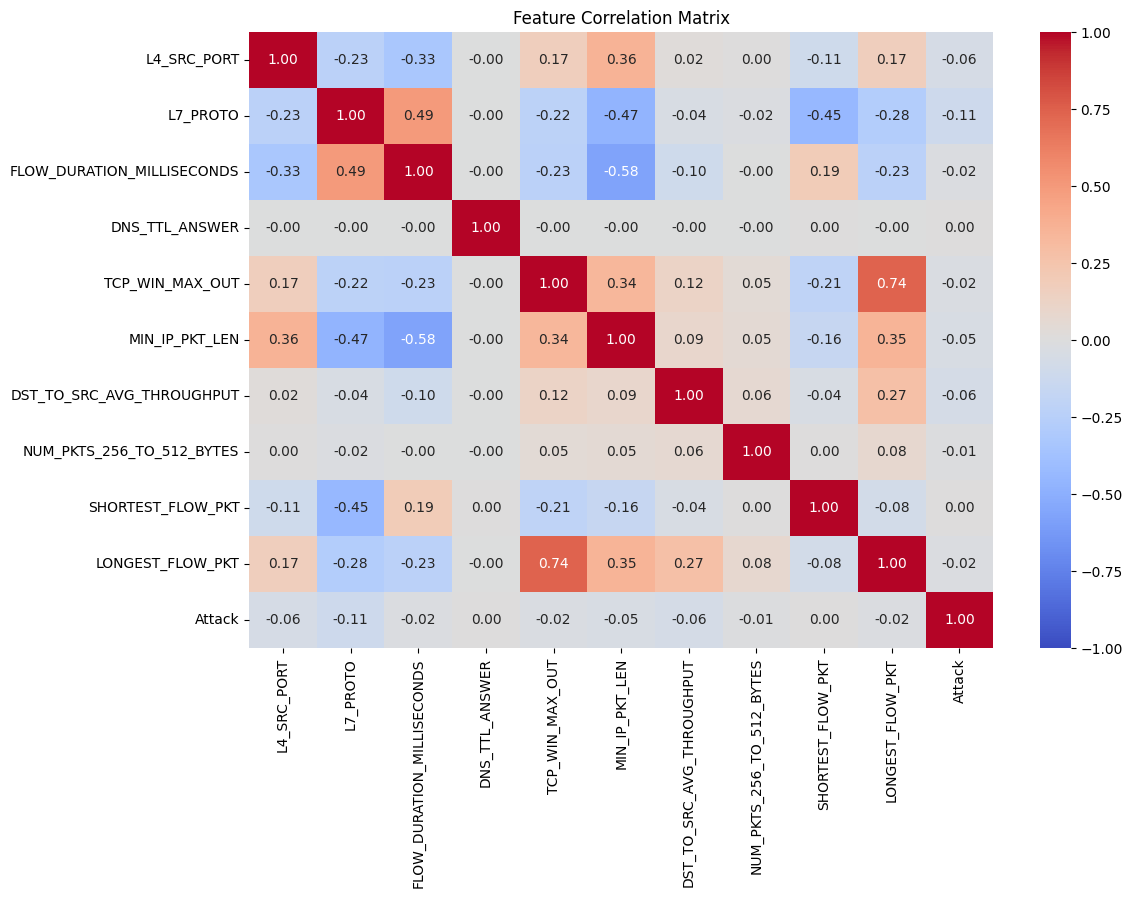

In [15]:
# 상관관계 매트릭스 계산
correlation_matrix = df_corr[cols].corr()

# 상관관계 매트릭스 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()


서로의 상관 관계를 봤을 때 다음과 같다

In [9]:
df_corr['DNS_TTL_ANSWER'].value_counts()

DNS_TTL_ANSWER
0       352749
60       27018
20        2049
59         899
30         755
         ...  
7823         1
641          1
1986         1
1516         1
3575         1
Name: count, Length: 2049, dtype: int64

공격과 정상의 비율 -> 실환경에서는 공격의 비율이 적음 그래서 실환경에서 사용하기에는 무리가 있을 수 있다.

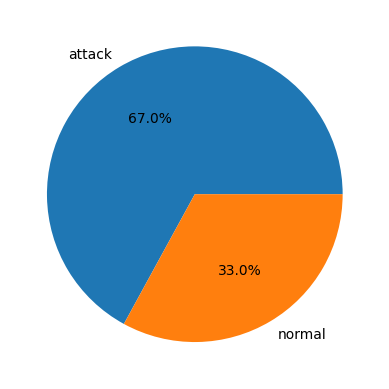

In [10]:
plt.pie(df3['Label'].value_counts(), labels=['attack', 'normal'], autopct='%.1f%%')
plt.show()

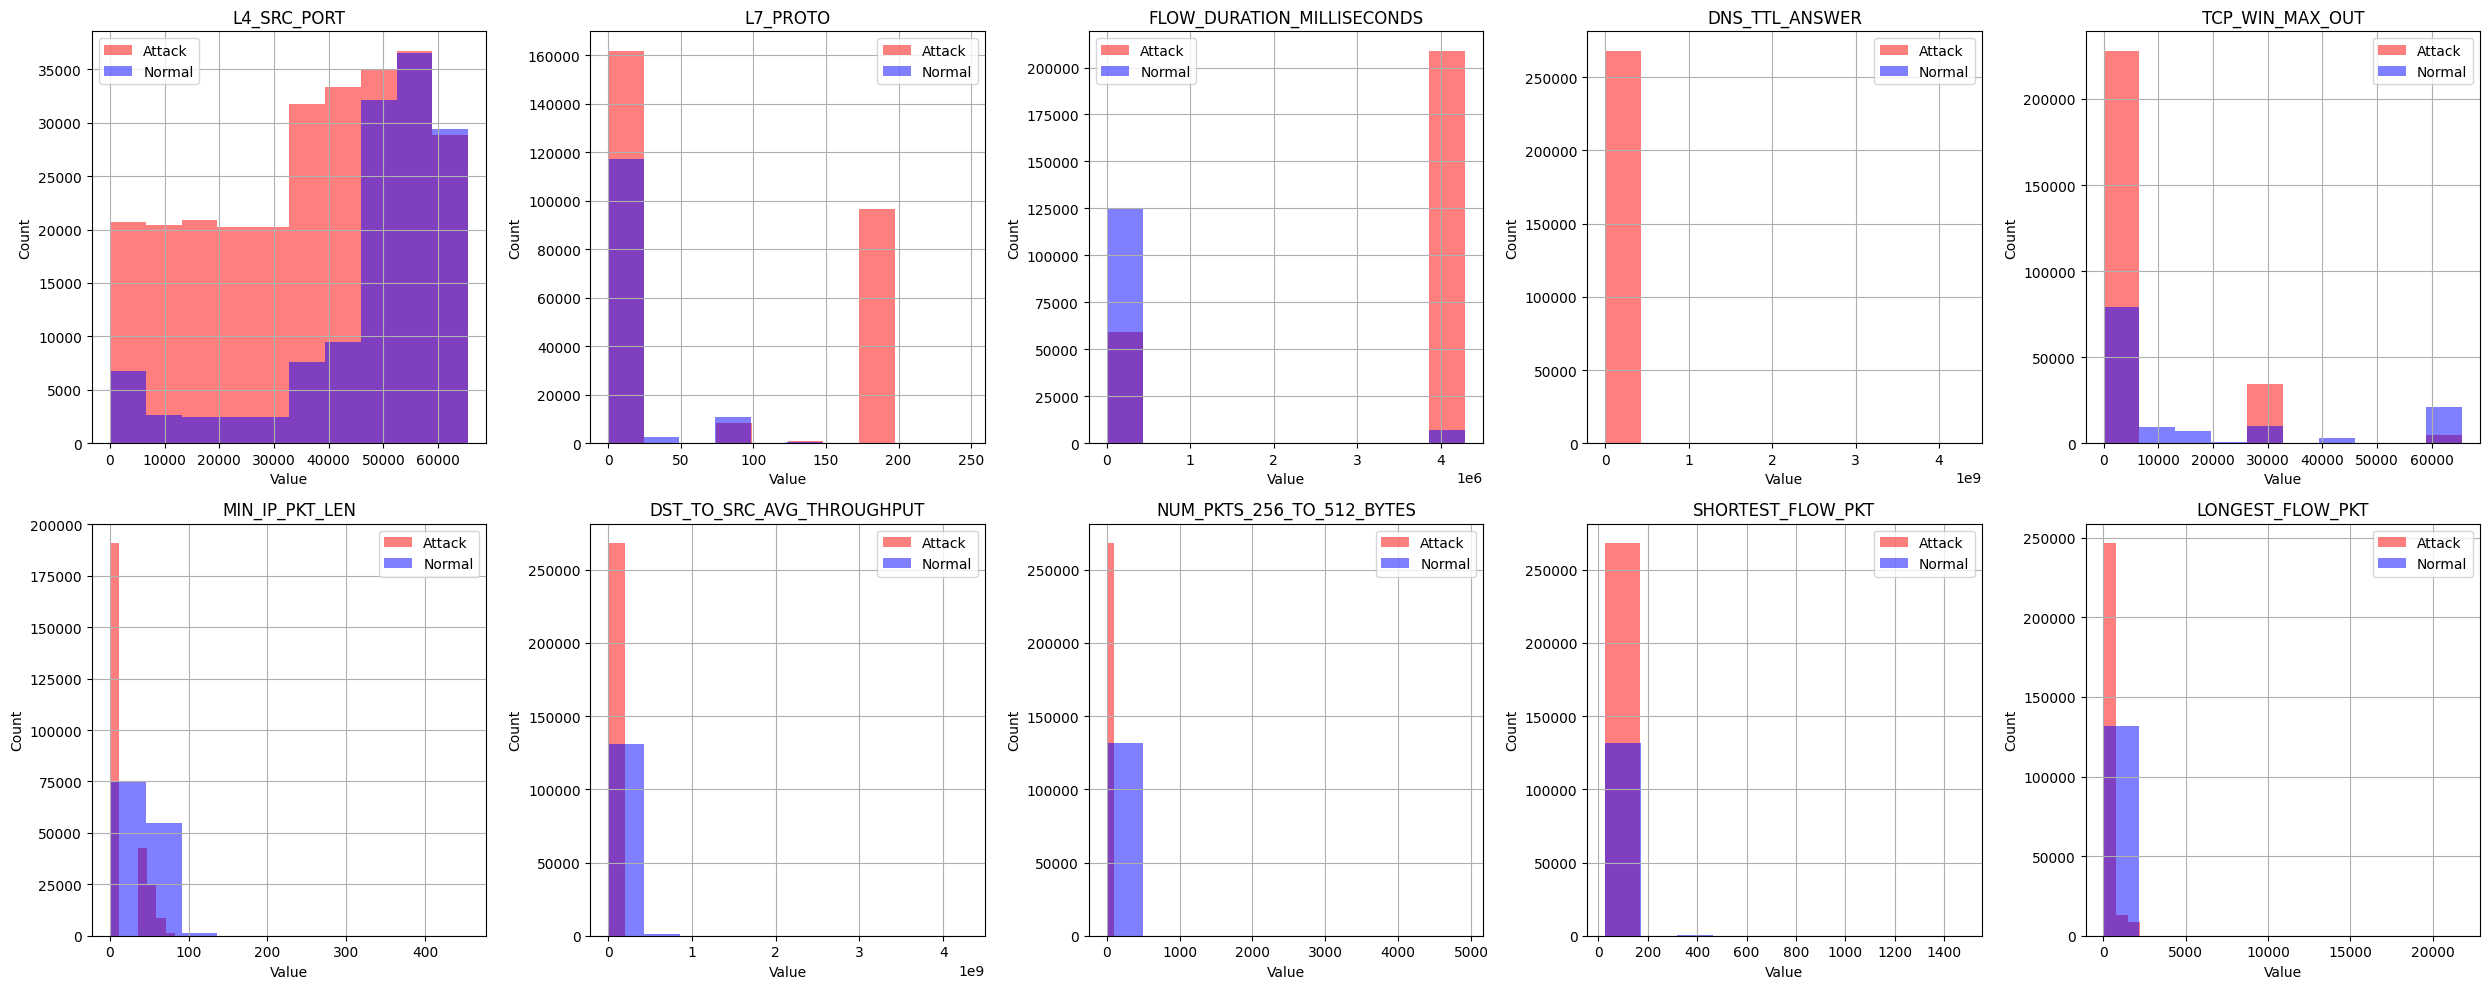

In [20]:
# 상위 10 공격과 정상 분포
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 10))
cols_index = ['L4_SRC_PORT','L7_PROTO','FLOW_DURATION_MILLISECONDS','DNS_TTL_ANSWER','TCP_WIN_MAX_OUT',
       'MIN_IP_PKT_LEN','DST_TO_SRC_AVG_THROUGHPUT','NUM_PKTS_256_TO_512_BYTES','SHORTEST_FLOW_PKT', 'LONGEST_FLOW_PKT']

for i, column in enumerate(cols_index, 1):
    plt.subplot(2, 5, i)
    plt.hist(df3[df3['Label']==1][column], label=f'Attack', color='red', alpha=0.5)
    plt.hist(df3[df3['Label']==0][column], label=f'Normal', color='blue', alpha=0.5)
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

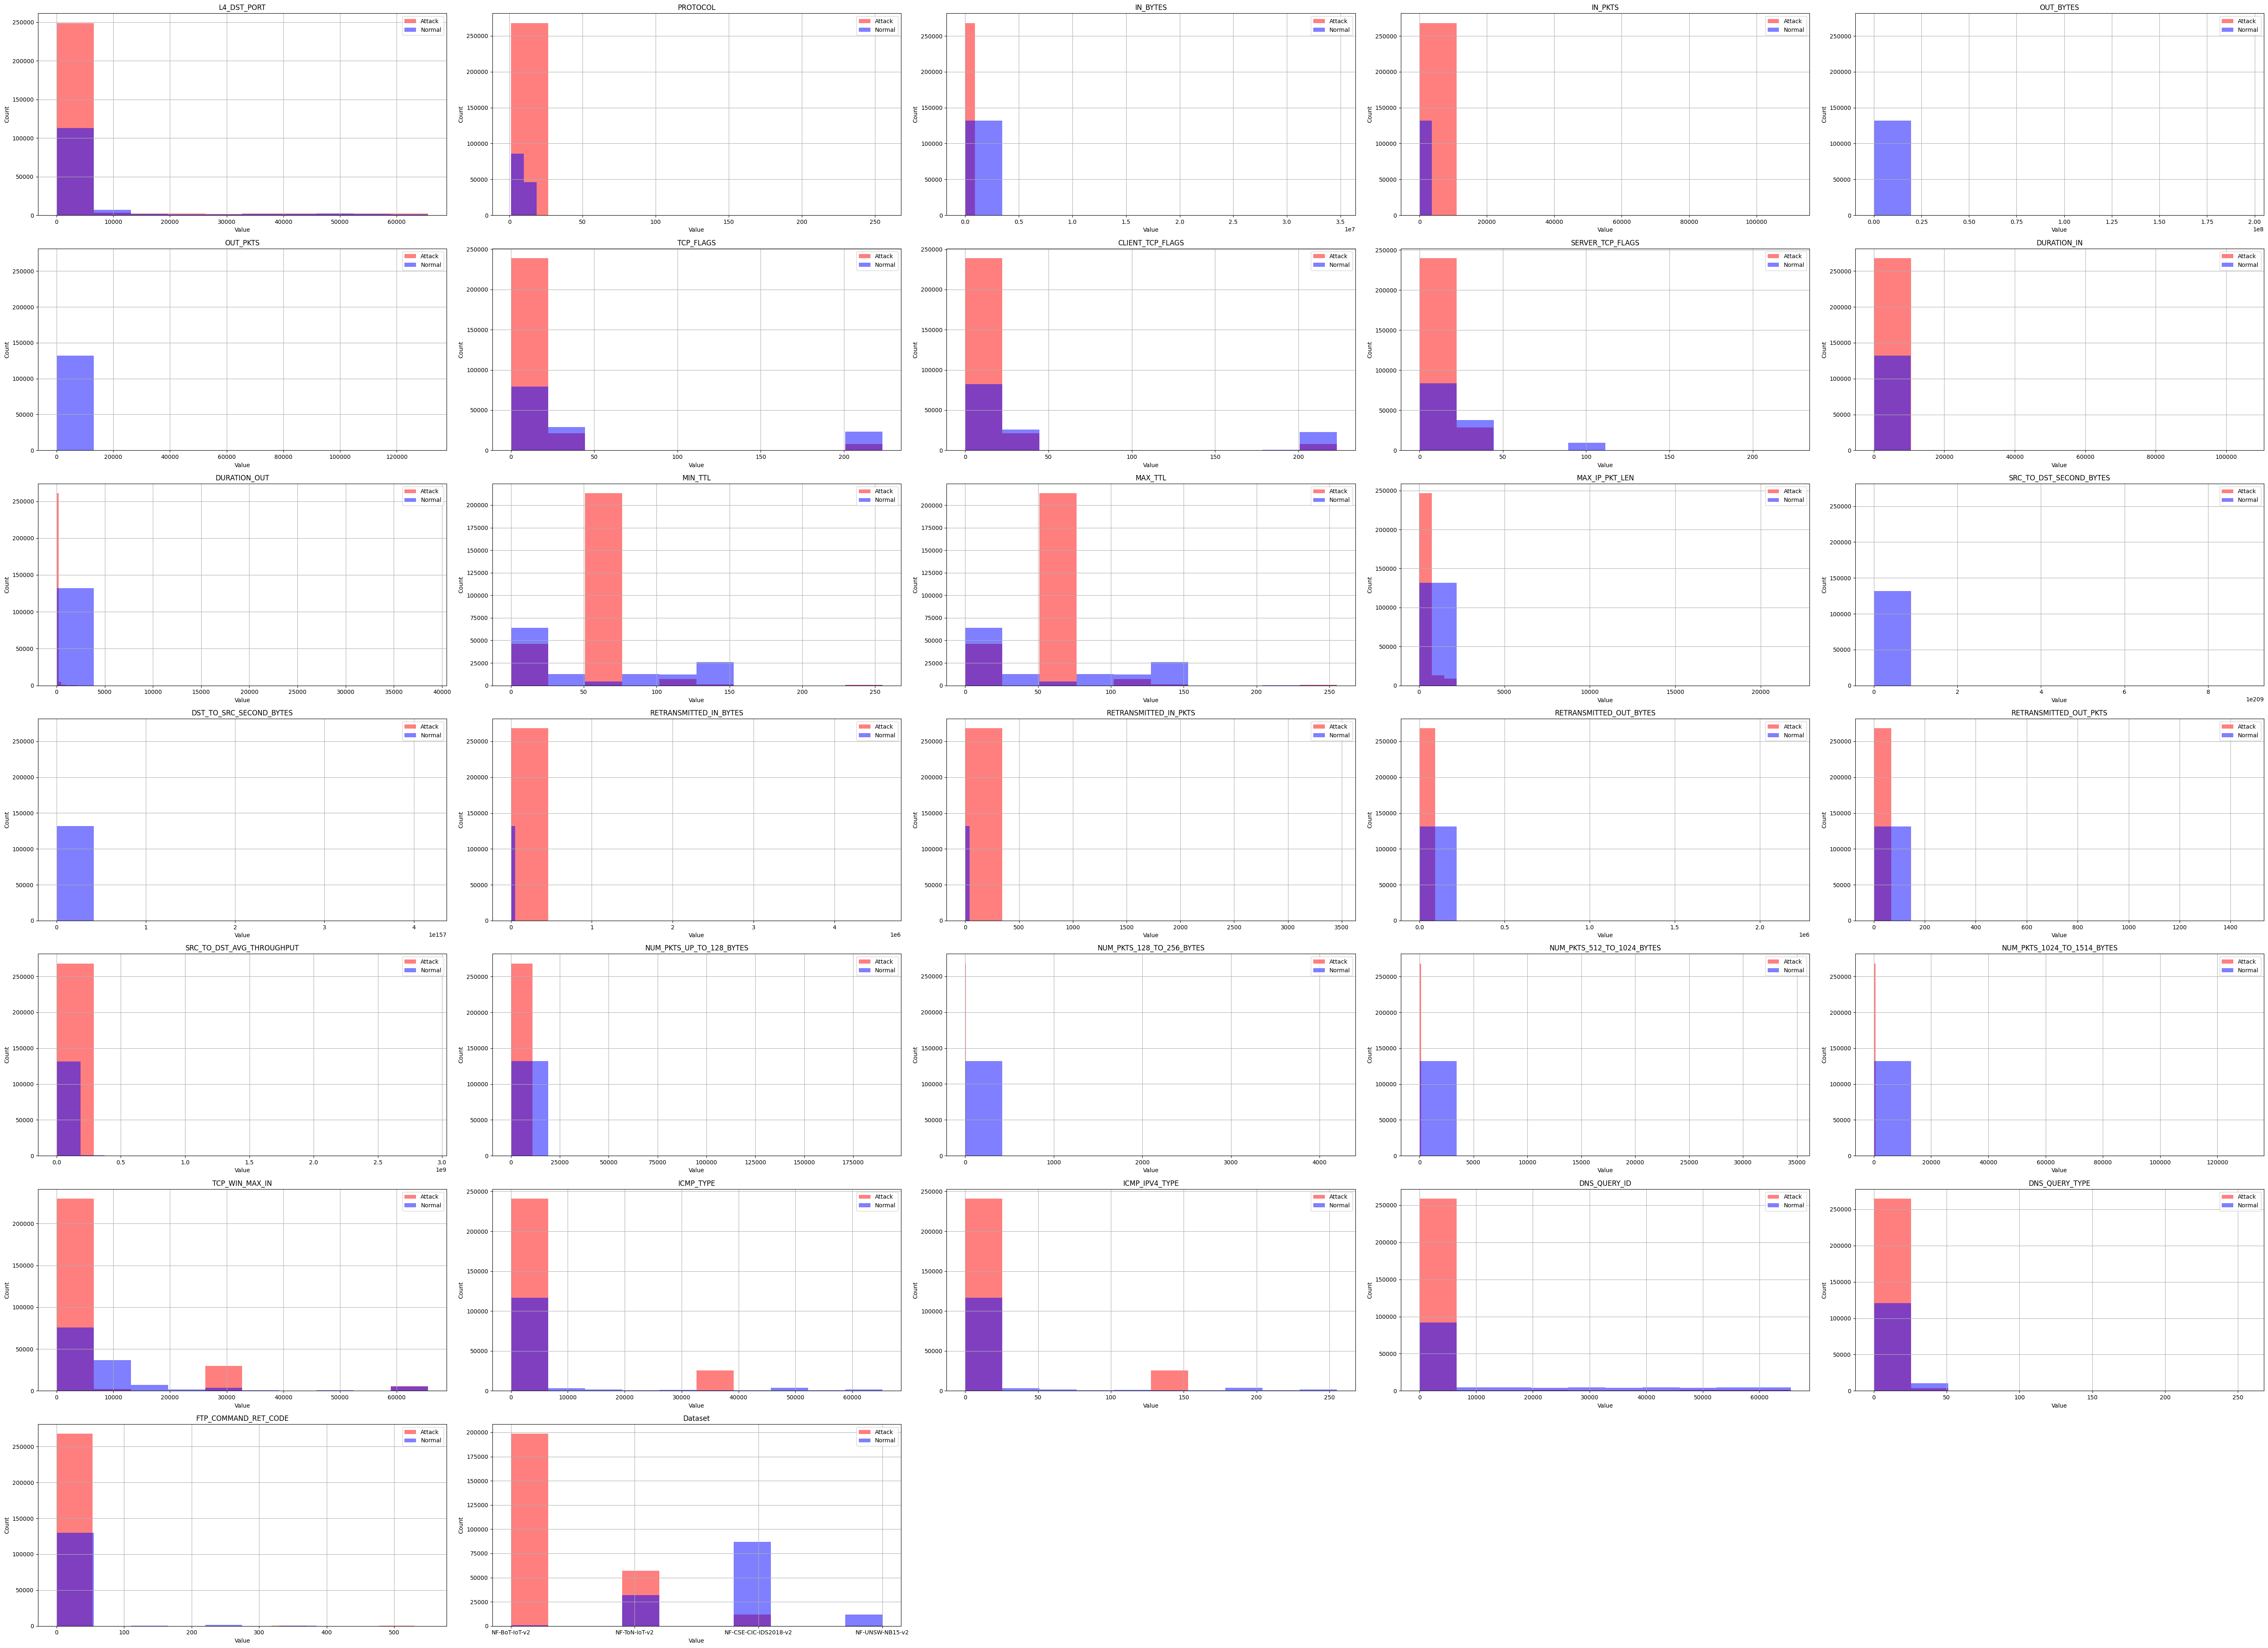

In [26]:
# 나머지 공격과 정상 분포
import matplotlib.pyplot as plt
plt.figure(figsize=(55, 40))
cols_index = ['IPV','L4_SRC_PORT','L7_PROTO','FLOW_DURATION_MILLISECONDS','DNS_TTL_ANSWER','TCP_WIN_MAX_OUT',
       'MIN_IP_PKT_LEN','DST_TO_SRC_AVG_THROUGHPUT','NUM_PKTS_256_TO_512_BYTES','SHORTEST_FLOW_PKT', 'LONGEST_FLOW_PKT', 'IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label']
col = list(df3.loc[:,~df3.columns.isin(cols_index)].columns)
for i, column in enumerate(col, 1):
    plt.subplot(7, 5, i)
    plt.hist(df3[df3['Label']==1][column], label=f'Attack', color='red', alpha=0.5)
    plt.hist(df3[df3['Label']==0][column], label=f'Normal', color='blue', alpha=0.5)
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [26]:
df3[df3['Label']==0]['DNS_TTL_ANSWER'].value_counts()

DNS_TTL_ANSWER
0         88808
60        26756
20         1999
59          866
30          726
          ...  
601362        1
1932          1
6761          1
857           1
8650          1
Name: count, Length: 748, dtype: int64

공격별 그래프를 확인했을 때 비슷한 형상을 띄는 것을 볼 수 있었음 -> 동건님 코드 참고